In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('merged dataset_FE_LM_GC_DC_class balancer.csv', sep=',', encoding='iso-8859-1')

## **PREDICTOR AND TARGET ATTRIBUTES**

In [3]:
predictors_chi_original = df.iloc[:, [10,11,13,14,15,17,19,21,22,23,25,30,31,33,34,35,37,40,44,54,60,61,62,63,64]].values

binary_target = df.iloc[:, 5].values
multiclass_target = df.iloc[:, 7].values

In [4]:

import warnings
warnings.filterwarnings("ignore")

# **Binary Code Smell Detection**

In [6]:
pip install seaborn

In [5]:
pip install catboost


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       134
         1.0       0.93      0.95      0.94       114

    accuracy                           0.94       248
   macro avg       0.94      0.94      0.94       248
weighted avg       0.94      0.94      0.94       248



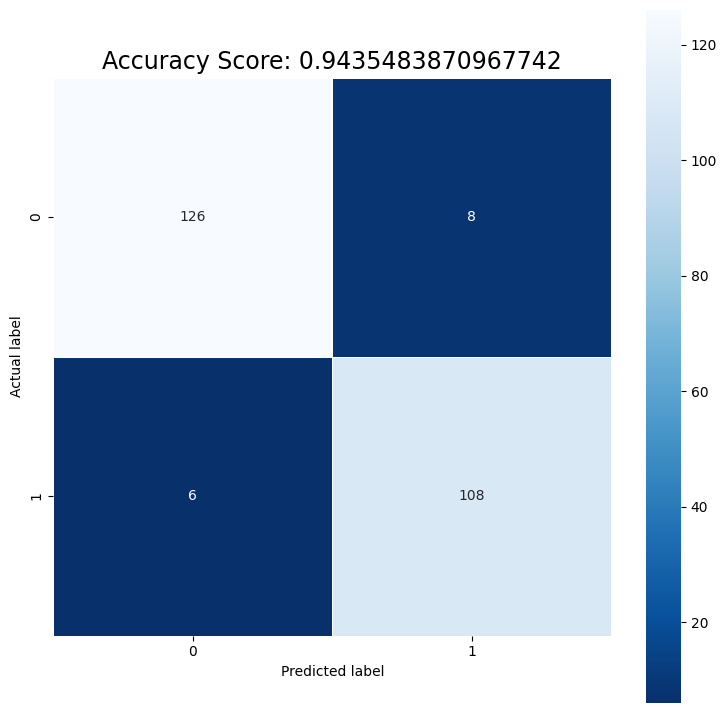

In [6]:
predictors_array = predictors_chi_original
r = 42

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(predictors_array, binary_target, test_size = 0.3, random_state = r)
x_train_multiclass, x_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(predictors_array, multiclass_target, test_size = 0.3, random_state = r)

# Define the detector model
detector = CatBoostClassifier(task_type='CPU', thread_count=-1, random_state = 42, verbose=False, learning_rate=0.01, leaf_estimation_method='Newton',
                              l2_leaf_reg=6, iterations=454, grow_policy='Lossguide', feature_border_type='UniformAndQuantiles',
                              depth=5, border_count=192, bootstrap_type='MVS', auto_class_weights='Balanced')

detector.fit(x_train_binary, y_train_binary)
predictions_detector = detector.predict(x_test_binary)


cm = confusion_matrix(y_test_binary, predictions_detector)

print(classification_report(y_test_binary, predictions_detector))

score = detector.score(x_test_binary, y_test_binary)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **Exclude instances of no-smell from the training and test sets**


In [6]:
finish = False
while (finish == False):
  try:
    max = x_train_multiclass.shape[0]
    # Exclude instances of no-smell from the training set (targets)
    for i in range(0, max):
      if (y_train_multiclass[i] == 0):
        y_train_multiclass = np.delete(y_train_multiclass, i, axis = 0)
        x_train_multiclass = np.delete(x_train_multiclass, i, axis = 0)
        i = 0
        max = max - 1
    finish = True
    print("The deletion is over in the y_train set!")
  except:
    finish == False


finish = False
while (finish == False):
  try:
    max = x_test_multiclass.shape[0]
    # Exclude instances of no-smell from the test set (predictors)
    for i in range(0, max):
      if (y_test_multiclass[i] == 0):
        y_test_multiclass = np.delete(y_test_multiclass, i, axis = 0)
        x_test_multiclass = np.delete(x_test_multiclass, i, axis = 0)
        i = 0
        max = max - 1
    finish = True
    print("The deletion is over in the x_train set!")
  except:
    finish = False

The deletion is over in the y_train set!
The deletion is over in the x_train set!


# Prepare training and test set for applying XGBoost

In [7]:
# Original mapping -> Remapping
mapping = {1.0: 0.0, 2.0: 1.0, 3.0: 2.0, 4.0: 3.0, 5.0: 4.0, 6.0: 5.0, 7.0: 6.0, 8.0: 7.0, 9.0: 8.0, 10.0: 9.0, 11.0: 10.0, 12.0: 11.0}

y_train_multiclass = np.array([mapping[label] for label in y_train_multiclass])
y_test_multiclass = np.array([mapping[label] for label in y_test_multiclass])

# **Code Smell Severity Classification with three ensemble method**


# **RANDOM FOREST**

In [ ]:
pip install imbalanced-learn

# **Randomized**

{'n_estimators': 970, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 6, 'criterion': 'log_loss', 'bootstrap': True};90.64;79.82
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         3
         1.0       0.70      0.88      0.78         8
         2.0       0.50      0.50      0.50         2
         3.0       0.00      0.00      0.00         2
         4.0       0.87      0.83      0.85        24
         5.0       0.78      0.88      0.82         8
         6.0       0.60      0.43      0.50         7
         7.0       0.73      0.89      0.80        18
         8.0       1.00      0.67      0.80         6
         9.0       1.00      0.50      0.67         2
        10.0       0.88      0.70      0.78        10
        11.0       0.89      1.00      0.94        24

    accuracy                           0.80       114
   macro avg       0.69      0.63      0.65       114
weighted avg       0.79  

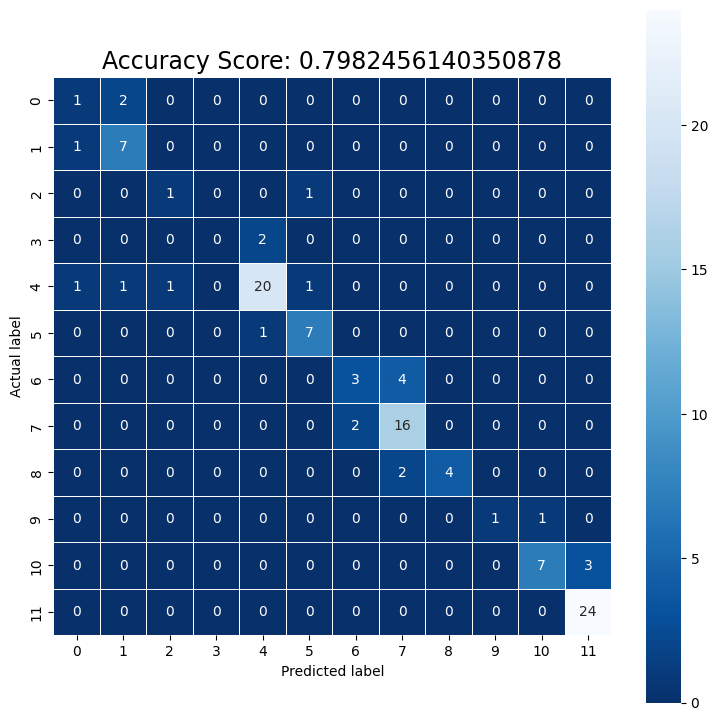

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'n_estimators': np.arange(50, 1000, 2),
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass, y_train_multiclass)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

{'n_estimators': 524, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'entropy', 'bootstrap': False};96.94;84.21
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         3
         1.0       0.80      1.00      0.89         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.82      0.96      0.88        24
         5.0       0.86      0.75      0.80         8
         6.0       0.71      0.71      0.71         7
         7.0       0.89      0.94      0.92        18
         8.0       1.00      0.83      0.91         6
         9.0       1.00      0.50      0.67         2
        10.0       0.78      0.70      0.74        10
        11.0       0.88      0.96      0.92        24

    accuracy                           0.84       114
   macro avg       0.73      0.64      0.66       114
weighted avg       0.

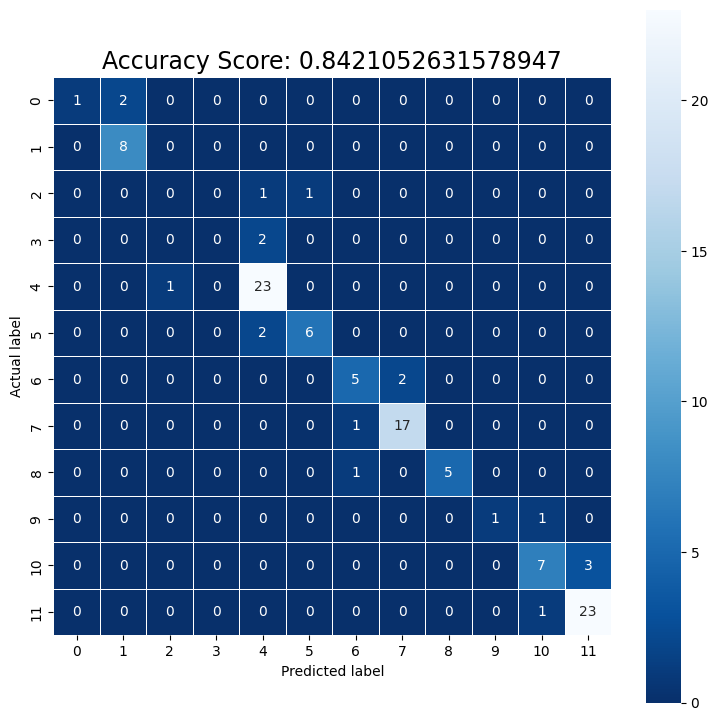

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'n_estimators': np.arange(50, 1000, 2),
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

{'n_estimators': 118, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'gini', 'bootstrap': False};97.79;78.95
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.70      0.88      0.78         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.81      0.92      0.86        24
         5.0       0.88      0.88      0.88         8
         6.0       0.50      0.57      0.53         7
         7.0       0.79      0.83      0.81        18
         8.0       1.00      0.67      0.80         6
         9.0       1.00      0.50      0.67         2
        10.0       0.78      0.70      0.74        10
        11.0       0.88      0.96      0.92        24

    accuracy                           0.79       114
   macro avg       0.61      0.57      0.58       114
weighted avg       0.76  

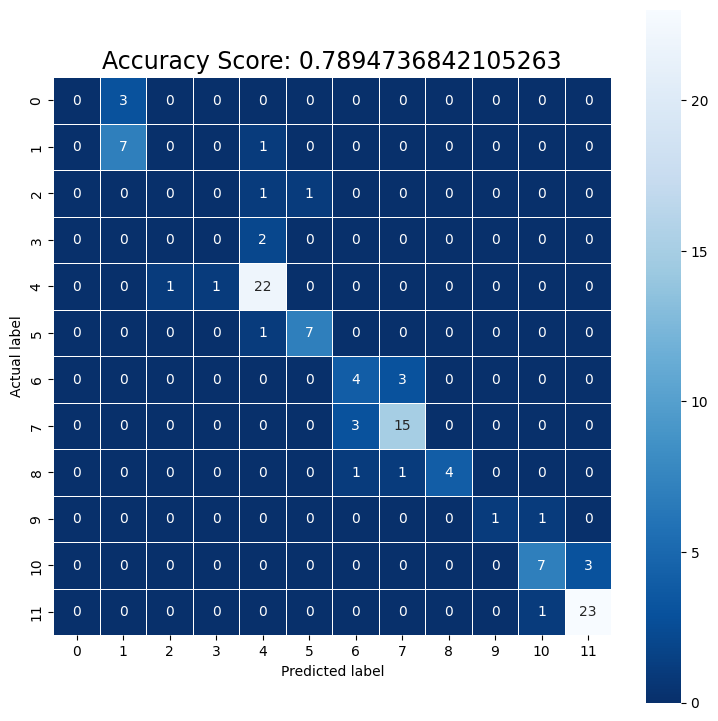

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'n_estimators': np.arange(50, 1000, 2),
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **EXTREME GRADIENTE BOOSTING (XGBOOST)**

# **Randomized**

{'tree_method': 'approx', 'objective': 'multi:softmax', 'n_estimators': 420, 'max_depth': 5, 'learning_rate': 0.5, 'grow_policy': 'lossguide', 'booster': 'gbtree'};99.67;78.07
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.70      0.88      0.78         8
         2.0       0.00      0.00      0.00         2
         3.0       1.00      0.50      0.67         2
         4.0       0.84      0.88      0.86        24
         5.0       0.75      0.75      0.75         8
         6.0       0.50      0.43      0.46         7
         7.0       0.72      0.72      0.72        18
         8.0       0.57      0.67      0.62         6
         9.0       1.00      0.50      0.67         2
        10.0       0.89      0.80      0.84        10
        11.0       0.92      1.00      0.96        24

    accuracy                           0.78       114
   macro avg       0.70      0.62      0.64       114
weighted avg

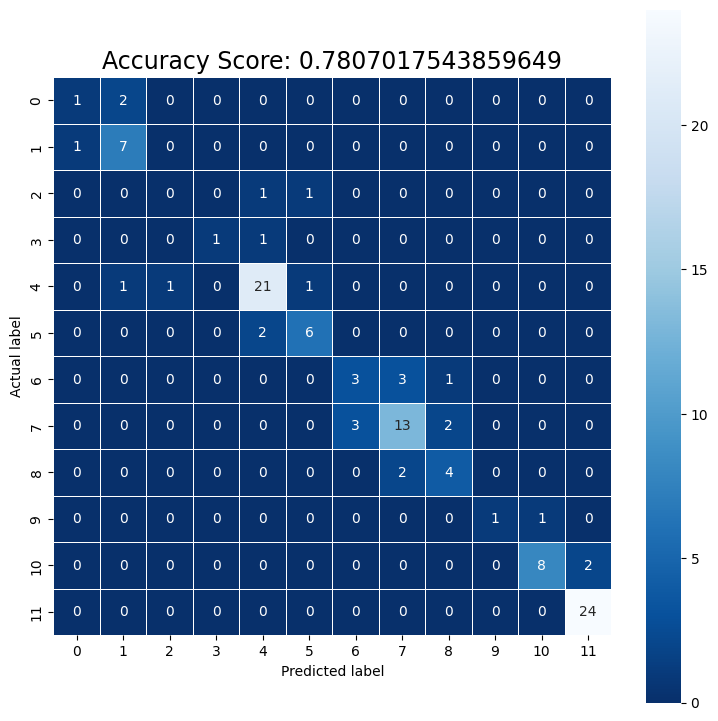

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the XGBoost model
xg = XGBClassifier(num_class=12, random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'objective': ['multi:softprob', 'multi:softmax'],
    'n_estimators': np.arange(50, 1000, 2),
    'max_depth': np.arange(1, 20, 1),
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['approx', 'hist'],
    'grow_policy' : ['depthwise', 'lossguide'],
    'learning_rate' : np.linspace(0.01, 0.5, 30)
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass, y_train_multiclass)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

{'tree_method': 'hist', 'objective': 'multi:softmax', 'n_estimators': 406, 'max_depth': 3, 'learning_rate': 0.3310344827586207, 'grow_policy': 'lossguide', 'booster': 'gbtree'};99.83;72.81
              precision    recall  f1-score   support

         0.0       0.25      0.33      0.29         3
         1.0       0.64      0.88      0.74         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.78      0.75      0.77        24
         5.0       0.86      0.75      0.80         8
         6.0       0.50      0.43      0.46         7
         7.0       0.70      0.78      0.74        18
         8.0       0.60      0.50      0.55         6
         9.0       1.00      0.50      0.67         2
        10.0       0.73      0.80      0.76        10
        11.0       0.92      0.92      0.92        24

    accuracy                           0.73       114
   macro avg       0.58      0.55      0.56       114

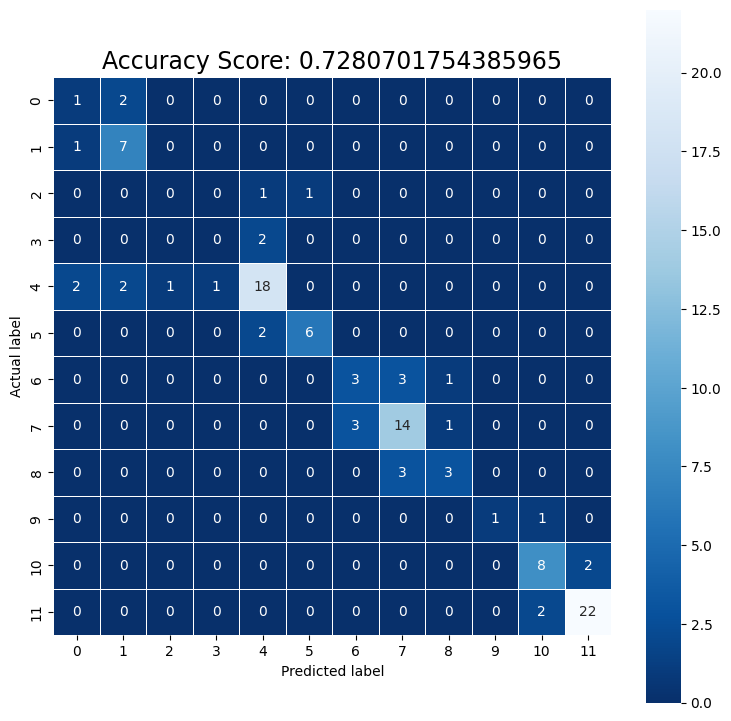

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import BorderlineSMOTE

# Define the XGBoost model
xg = XGBClassifier(num_class=12, random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'objective': ['multi:softprob', 'multi:softmax'],
    'n_estimators': np.arange(50, 1000, 2),
    'max_depth': np.arange(1, 20, 1),
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['approx', 'hist'],
    'grow_policy' : ['depthwise', 'lossguide'],
    'learning_rate' : np.linspace(0.01, 0.5, 30)
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)


print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

{'tree_method': 'approx', 'objective': 'multi:softprob', 'n_estimators': 586, 'max_depth': 5, 'learning_rate': 0.5, 'grow_policy': 'lossguide', 'booster': 'dart'};99.83;75.44
              precision    recall  f1-score   support

         0.0       0.25      0.33      0.29         3
         1.0       0.67      0.75      0.71         8
         2.0       0.00      0.00      0.00         2
         3.0       0.50      0.50      0.50         2
         4.0       0.82      0.75      0.78        24
         5.0       0.75      0.75      0.75         8
         6.0       0.50      0.43      0.46         7
         7.0       0.74      0.78      0.76        18
         8.0       0.67      0.67      0.67         6
         9.0       1.00      0.50      0.67         2
        10.0       0.75      0.90      0.82        10
        11.0       0.96      0.96      0.96        24

    accuracy                           0.75       114
   macro avg       0.63      0.61      0.61       114
weighted avg 

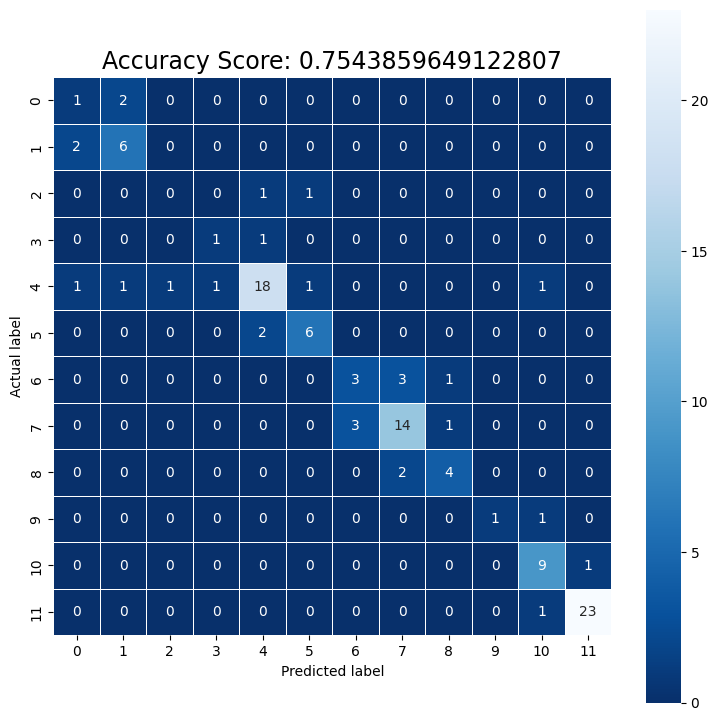

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import BorderlineSMOTE

# Define the XGBoost model
xg = XGBClassifier(num_class=12, random_state=42)

# Define the hyperparameter grid for the search
param_dist = {
    'objective': ['multi:softprob', 'multi:softmax'],
    'n_estimators': np.arange(50, 1000, 2),
    'max_depth': np.arange(1, 20, 1),
    'booster' : ['gbtree', 'dart'],
    'tree_method' : ['approx', 'hist'],
    'grow_policy' : ['depthwise', 'lossguide'],
    'learning_rate' : np.linspace(0.01, 0.5, 30)
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42, n_jobs=-1)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass_res)
accuracy_train = accuracy_score(y_train_multiclass_res, y_pred_train)


print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **CATEGORICAL BOOSTING (CATBOOST)**

In [8]:
pip install catboost


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# **Randomized**

{'learning_rate': 0.16206896551724137, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 7, 'iterations': 592, 'grow_policy': 'Lossguide', 'feature_border_type': 'Uniform', 'depth': 6, 'border_count': 192, 'bootstrap_type': 'MVS', 'auto_class_weights': 'Balanced'};98.33;78.07
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.78      0.88      0.82         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.81      0.88      0.84        24
         5.0       0.78      0.88      0.82         8
         6.0       0.50      0.57      0.53         7
         7.0       0.78      0.78      0.78        18
         8.0       0.80      0.67      0.73         6
         9.0       1.00      0.50      0.67         2
        10.0       0.78      0.70      0.74        10
        11.0       0.88      0.96      0.92        24

    accuracy      

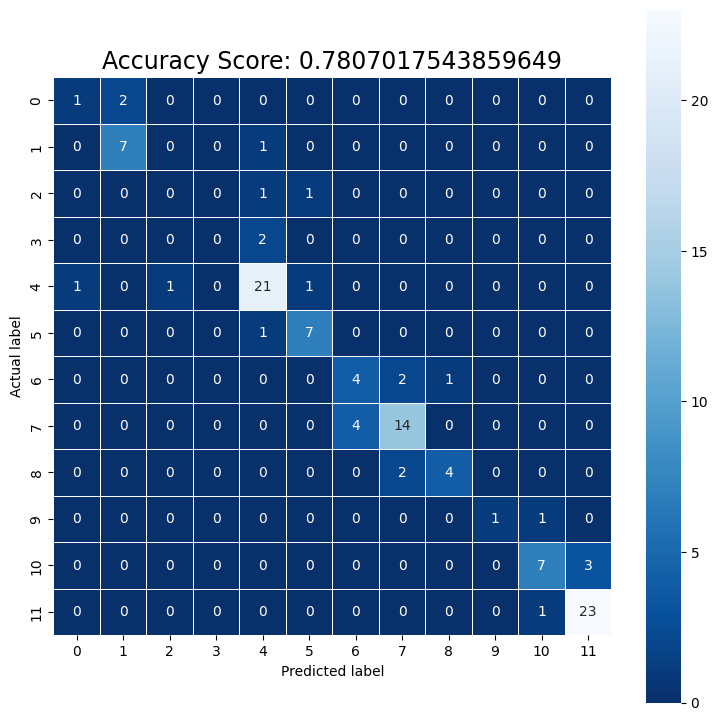

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the CatBoost model
cat = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass')

# Define the hyperparameter grid for the search
param_dist = {
    'iterations': np.arange(50, 1000, 2),
    'depth': np.arange(1, 16, 1),
    'learning_rate': np.linspace(0.01, 0.5, 30),
    'l2_leaf_reg': np.arange(1, 10, 1),
    'border_count': np.arange(32, 256, 16),
    'feature_border_type' : ['Median', 'Uniform', 'UniformAndQuantiles', 'GreedyLogSum', 'MaxLogSum', 'MinEntropy'],
    'leaf_estimation_method' : ['Newton', 'Gradient'],
    'auto_class_weights' : ['Balanced', 'SqrtBalanced'],
    'grow_policy' : ['SymmetricTree', 'Lossguide', 'Depthwise'],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS', 'No']
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cat, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42)

# Adjust the model
random_search.fit(x_train_multiclass, y_train_multiclass)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)


print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

# **BorderlineSMOTE**

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# OverSampling
sm = BorderlineSMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

{'learning_rate': 0.3310344827586207, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 6, 'iterations': 734, 'grow_policy': 'Depthwise', 'feature_border_type': 'GreedyLogSum', 'depth': 15, 'border_count': 96, 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'SqrtBalanced'};99.33;80.70
              precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.80      1.00      0.89         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.83      0.83      0.83        24
         5.0       0.78      0.88      0.82         8
         6.0       0.56      0.71      0.62         7
         7.0       0.88      0.78      0.82        18
         8.0       0.83      0.83      0.83         6
         9.0       1.00      0.50      0.67         2
        10.0       0.80      0.80      0.80        10
        11.0       0.92      0.96      0.94        24

    a

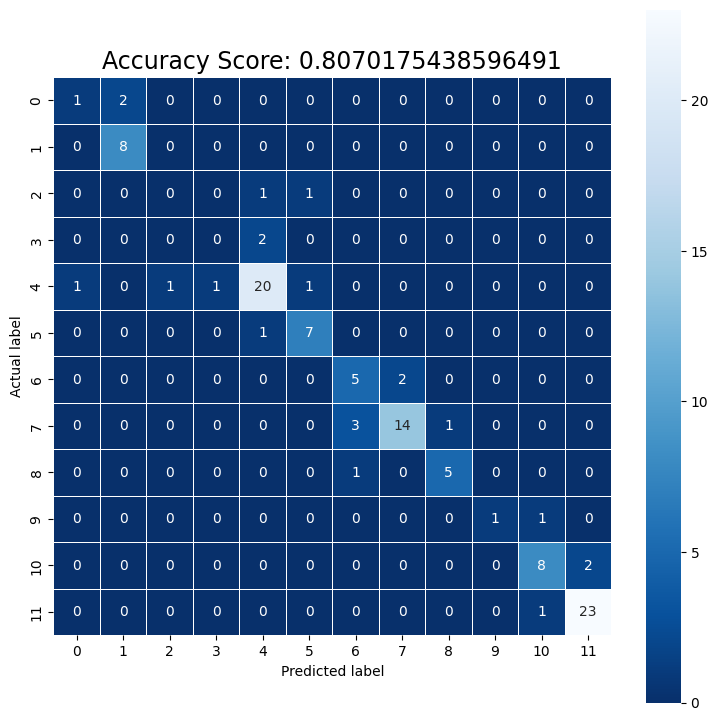

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the CatBoost model
cat = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass')

# Define the hyperparameter grid for the search
param_dist = {
    'iterations': np.arange(50, 1000, 2),
    'depth': np.arange(1, 16, 1),
    'learning_rate': np.linspace(0.01, 0.5, 30),
    'l2_leaf_reg': np.arange(1, 10, 1),
    'border_count': np.arange(32, 256, 16),
    'feature_border_type' : ['Median', 'Uniform', 'UniformAndQuantiles', 'GreedyLogSum', 'MaxLogSum', 'MinEntropy'],
    'leaf_estimation_method' : ['Newton', 'Gradient'],
    'auto_class_weights' : ['Balanced', 'SqrtBalanced'],
    'grow_policy' : ['SymmetricTree', 'Lossguide', 'Depthwise'],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS', 'No']
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cat, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)


print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()

## **SMOTE**

In [9]:
from imblearn.over_sampling import SMOTE

# OverSampling
sm = SMOTE(random_state=42)
x_train_multiclass_res, y_train_multiclass_res = sm.fit_resample(x_train_multiclass, y_train_multiclass)

{'learning_rate': 0.07758620689655171, 'leaf_estimation_method': 'Gradient', 'l2_leaf_reg': 8, 'iterations': 548, 'grow_policy': 'Depthwise', 'feature_border_type': 'GreedyLogSum', 'depth': 6, 'border_count': 208, 'bootstrap_type': 'Bayesian', 'auto_class_weights': 'Balanced'};99.67;78.07
              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33         3
         1.0       0.62      0.62      0.62         8
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         2
         4.0       0.78      0.88      0.82        24
         5.0       0.86      0.75      0.80         8
         6.0       0.57      0.57      0.57         7
         7.0       0.78      0.78      0.78        18
         8.0       0.83      0.83      0.83         6
         9.0       1.00      0.50      0.67         2
        10.0       0.82      0.90      0.86        10
        11.0       0.96      0.96      0.96        24

    ac

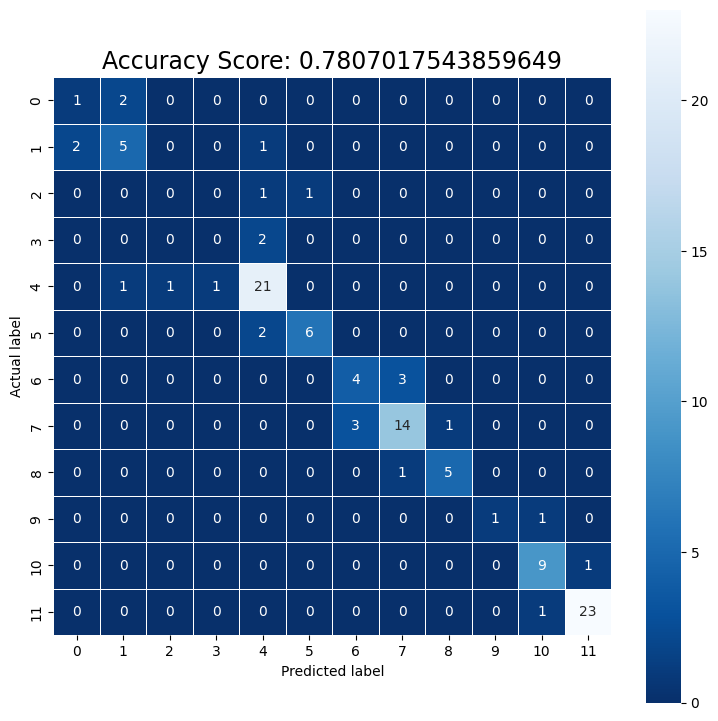

In [10]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the CatBoost model
cat = CatBoostClassifier(task_type='CPU', random_state = 42, verbose=False, classes_count=12, objective='MultiClass')

# Define the hyperparameter grid for the search
param_dist = {
    'iterations': np.arange(50, 1000, 2),
    'depth': np.arange(1, 16, 1),
    'learning_rate': np.linspace(0.01, 0.5, 30),
    'l2_leaf_reg': np.arange(1, 10, 1),
    'border_count': np.arange(32, 256, 16),
    'feature_border_type' : ['Median', 'Uniform', 'UniformAndQuantiles', 'GreedyLogSum', 'MaxLogSum', 'MinEntropy'],
    'leaf_estimation_method' : ['Newton', 'Gradient'],
    'auto_class_weights' : ['Balanced', 'SqrtBalanced'],
    'grow_policy' : ['SymmetricTree', 'Lossguide', 'Depthwise'],
    'bootstrap_type' : ['Bayesian', 'Bernoulli', 'MVS', 'No']
}

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cat, param_distributions=param_dist, scoring='f1_macro', n_iter=50, cv=5, random_state=42)

# Adjust the model
random_search.fit(x_train_multiclass_res, y_train_multiclass_res)

# Best hyperparameter combination
best_params = random_search.best_params_

# Evaluate the optimized model on the test set
best_estimator = random_search.best_estimator_

y_pred_test = best_estimator.predict(x_test_multiclass)
accuracy_test = accuracy_score(y_test_multiclass, y_pred_test)

y_pred_train = best_estimator.predict(x_train_multiclass)
accuracy_train = accuracy_score(y_train_multiclass, y_pred_train)


print(f"{best_params};{accuracy_train*100:.2f};{accuracy_test*100:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_multiclass, y_pred_test)

print(classification_report(y_test_multiclass, y_pred_test))

score = best_estimator.score(x_test_multiclass, y_test_multiclass)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 17)
#plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
plt.show()